In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

import seaborn as sns
import geopandas as gpd
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error


#---------------------------------------------------
# for plotting purposes we use this iPython magic
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (19, 19)
#---------------------------------------------------

Populating the interactive namespace from numpy and matplotlib


In [2]:
gdf = gpd.read_file('/home/vollrath/Indonesia_sm/gdf_s1_aux.gpkg')
len(gdf.station.unique())
gdf['index'] = pd.to_datetime(gdf['index'], format='%d/%m/%Y')
gdf = gdf.set_index('index').dropna()
len(gdf)

2928

In [3]:
field = pd.read_pickle('/home/vollrath/Indonesia_sm/cleaned_station_data/cleaned_field_stations.pickle')
print(len(field))
print(field.columns)
# turn into geopandas
#geo_field = gpd.GeoDataFrame(field, geometry=gpd.points_from_xy(field.lon, field.lat))
#geo_field.to_file('/home/vollrath/Indonesia_sm/geo_field_clean.gpkg', driver='GPKG')

26813
Index(['station', 'location', 'province', 'lon', 'lat', 'GWL_max', 'GWL_min',
       'GWL_rata', 'SM_max', 'SM_min', 'SM_rata', 'Total'],
      dtype='object')


In [4]:
for i, station in enumerate(gdf.station.unique()):
    
    new_df = gdf[gdf.station == station]
    idx_field = field.index[field.station == station]
    if i == 0:
        clean_df = new_df[new_df.index.isin(idx_field)]
    else:
        clean_df = clean_df.append(new_df[new_df.index.isin(idx_field)])

print(len(clean_df))

2533


In [ ]:
stations = gpd.read_file('/home/vollrath/Indonesia_sm/stations_pix_corr.shp')

station_trusted = [
    'BRG_621103_05',
    'BRG_621103_04',
    'BRG_621103_01',
    'BRG_621103_02',
    'BRG_621103_06',
    'BRG_621103_03'
]
stat_trusted = [
'BRG_150706_01',
'BRG_150709_01',
'BRG_150710_01',
'BRG_150710_03',
'BRG_610207_01',
'BRG_610207_02',
'BRG_610216_01',
'BRG_611203_01',
'BRG_611209_01',
'BRG_621101_02',
'BRG_621103_01',
'BRG_621103_02',
'BRG_621103_03',
'BRG_621103_04',
'BRG_621103_05',
'BRG_621103_06',
'BRG_621105_03',
'BRG_621107_03',
'BRG_621107_05',
'BRG_621107_06',
'BRG_621107_07',
'BRG_621108_01',
'BRG_910111_01',
'kalbar1',
'kalteng1'
]

#stat_trusted = ['BRG_621103_02', 'kalteng1', 'BRG_621103_01', 'BRG_621103_06',
#       'BRG_621107_03', 'BRG_621107_06', 'BRG_150710_01', 'BRG_621107_05',
#       'BRG_621103_05', 'BRG_150710_03', 'BRG_621103_04', 'BRG_610207_01',
#       'BRG_621108_01', 'BRG_610216_01', 'BRG_910111_01', 'BRG_621105_03']

stat_high = stations.stasiun[(stations['corr_sm'] >= 0.5)]
stat_med = stations.stasiun[(stations['corr_gwl'] < 0.5) & (stations['corr_gwl'] >= 0.3)]
stat_low = stations.stasiun[(stations['corr_gwl'] < 0.3)] 
len(stat_trusted)
np.random.choice(stat_trusted, size=20)

array(['kalteng1', 'BRG_611209_01', 'kalbar1', 'BRG_150706_01',
       'BRG_621107_06', 'BRG_910111_01', 'BRG_150710_03', 'BRG_610207_01',
       'BRG_910111_01', 'BRG_621103_04', 'BRG_621101_02', 'BRG_610216_01',
       'BRG_621103_04', 'BRG_621107_03', 'BRG_621103_03', 'BRG_621103_04',
       'BRG_621103_04', 'BRG_621103_02', 'BRG_621107_03', 'BRG_611209_01'],
      dtype='<U13')

In [9]:
bandlist = [
     'orbit_direction',
     'VV', 'VH', 'VVVH_ratio', 'angle', 'LIA', #'layover', 'shadow', 'no_data_mask', 
     'precipitation', 'prec_3', 'prec_7', 'prec_30', 
     #'gldas_mean', 'gldas_stddev',
     'sm_1',  'sm_3', 'sm_7', 'sm_30',
     #'elevation', 'aspect', 'slope', 
     #'landcover',
     'kVV_mean', 'kVV_stdDev', 
     'kVV_p5', 'kVV_p95',
     'kVH_mean', 'kVH_stdDev', 
     'kVH_p5', 'kVH_p95', 
     'VV_mean', 'VV_stdDev', 
     'VV_p5', 'VV_p95', 
     'VH_mean', 'VH_stdDev', 
     'VH_p5', 'VH_p95'
    ]

#X = gdf_high[bandlist]
#y = gdf_high['SM_rata']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

temporal_expl = [
    'VV', 'VH', 'VVVH_ratio', 
    'precipitation', 'prec_3', 'prec_7', 'prec_30', 
    'sm_1',  'sm_3', 'sm_7', 'sm_30'
]

cols = ['r_pysmm_gwl_rata', 'r_local_gwl_rata', 'rmse_local'] #, 'r2_rf'] 
cols.extend(temporal_expl)
print(cols)

['r_pysmm_gwl_rata', 'r_local_gwl_rata', 'rmse_local', 'VV', 'VH', 'VVVH_ratio', 'precipitation', 'prec_3', 'prec_7', 'prec_30', 'sm_1', 'sm_3', 'sm_7', 'sm_30']


# All but one station test

In [ ]:
gdf_high = clean_df[clean_df.station.isin(stat_trusted)].copy()

variable = 'GWL_rata'
row = {}
for i, station in enumerate(gdf_high.station.unique()):
    
    
    # add first element gwl-smm correlation to station
    explans = [stations['corr_gwl'][stations.stasiun == station].values[0]]
    
    # create a df for training without the station
    gdf_train = gdf_high[gdf_high.station != station]
    
    # create a df for test of the station
    gdf_test = gdf_high[gdf_high.station == station]
        
    X_train, X_test = gdf_train[bandlist], gdf_test[bandlist]
    y_train, y_test = gdf_train[variable], gdf_test[variable]
    
    regr = RandomForestRegressor(n_estimators=250, min_samples_leaf=1, random_state=42, oob_score=True, criterion='mse', n_jobs=-1)
    regr.fit(X_train, y_train)
    y_pred_test = regr.predict(X_test)
    
    r, p = pearsonr(gdf_test[variable].values, y_pred_test)
    explans.append(r)
    
    #r2 = r2_score(y_test, y_pred_test)
    #explans.append(r2)
    
    # add correlation of explanatories
    for expl in temporal_expl:
        explans.append(gdf_test[variable].corr(gdf_test[expl]))
        
    row[station] = explans
    
stats_df = pd.DataFrame.from_dict(row, orient='index')

In [ ]:
stats_df.columns = cols
stats_df.loc['mean'] = stats_df.mean()
sns.heatmap(stats_df, annot=True)
#plt.savefig('/home/vollrath/Indonesia_sm/figures/correlations/correlation_gwl_clean_trusted.png')

# Best station train, others test test

In [10]:
# split gdf into good statoins for train
gdf_high = clean_df[clean_df.station.isin(stat_trusted)].copy()
# and bad stations for test
gdf_low = clean_df[~clean_df.station.isin(stat_trusted)].copy()

variable = 'GWL_rata'

# create and train classifier
regr = RandomForestRegressor(n_estimators=250, min_samples_leaf=1, random_state=42, oob_score=True, criterion='mse', n_jobs=-1)
regr.fit(gdf_high[bandlist], gdf_high[variable])


row = {}
#rmse_list = []
for station in gdf_low.station.unique():
    
    # add first element gwl-smm correlation to station
    explans = [stations['corr_gwl'][stations.stasiun == station].values[0]]
    
    # apply model to specific station
    gdf_test = gdf_low[gdf_low.station == station]
    y_pred_test = regr.predict(gdf_test[bandlist])
    
    # get pearsons r
    r, p = pearsonr(gdf_test[variable].values, y_pred_test)
    explans.append(r)
    
    explans.append(np.sqrt(mean_squared_error(gdf_test[variable].values, y_pred_test)))

    # add correlation of explanatories
    for expl in temporal_expl:
        explans.append(gdf_test[variable].corr(gdf_test[expl]))
     
    row[station] = explans
    #row[station] = [np.sqrt(mean_squared_error(gdf_test[variable].values, y_pred_test))]
    #print(row)
    
stats_df = pd.DataFrame.from_dict(row, orient='index')

59


<AxesSubplot:>

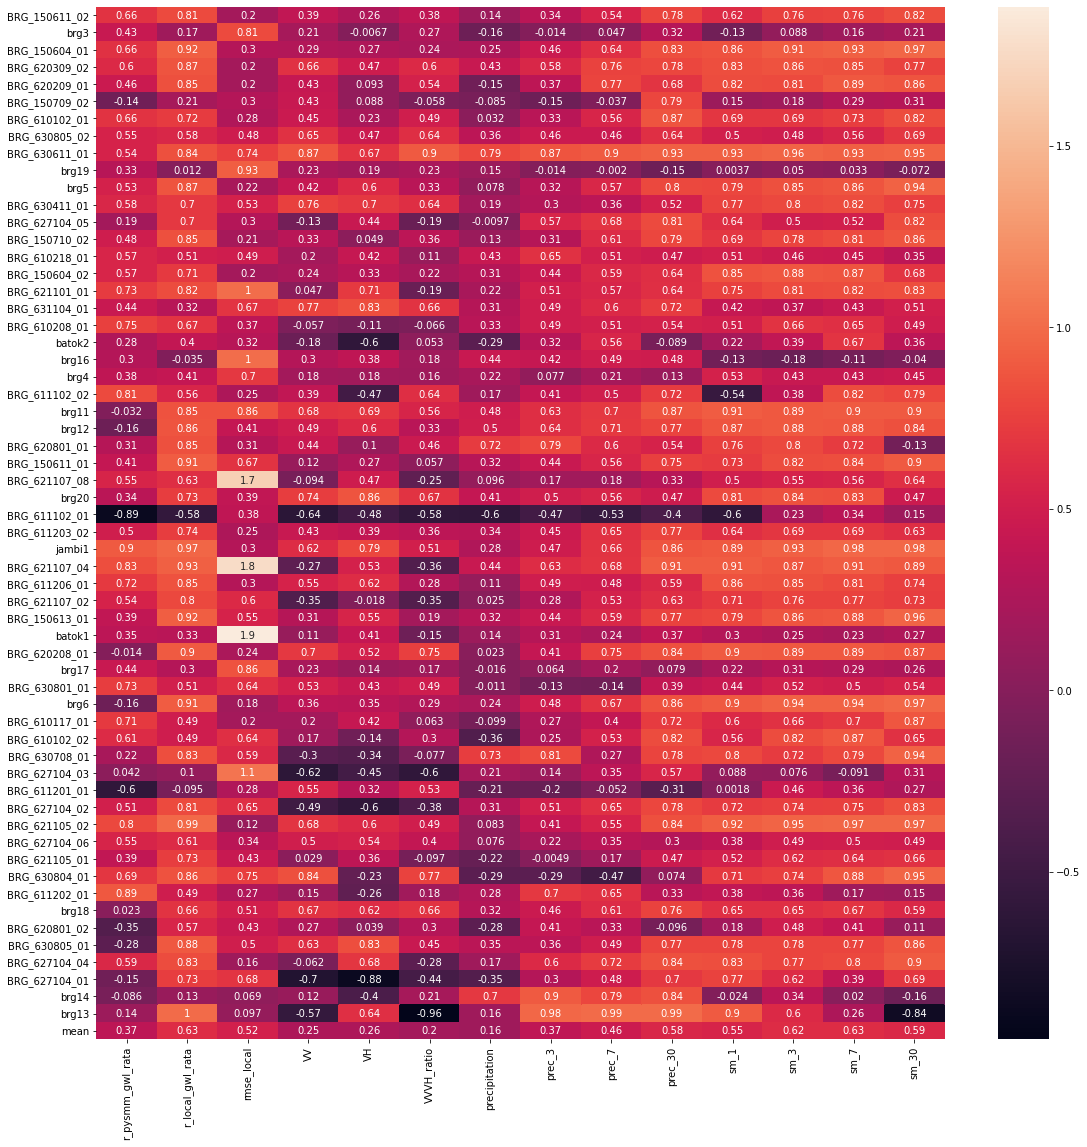

In [11]:
#stats_df.columns = ['rmse']
stats_df.columns = cols

#stats_df = stats_df[stats_df.r_pysmm_gwl_rata > 0.5]
print(len(stats_df))
#print(len(stats_df[stats_df.r_pysmm_gwl_rata > 0.5]), len(stats_df[stats_df.r_local_gwl_rata > 0.5]))
stats_df.loc['mean'] = stats_df.mean()
stats_df
sns.heatmap(stats_df, annot=True)
#plt.savefig('/home/vollrath/Indonesia_sm/figures/correlations/correlation_GWL_cleaned_others.png')

# Final model bootstrap

In [22]:
first_stations = stat_trusted.copy()
additional_stations = stats_df.index[stats_df.rmse_local < 0.31]
first_stations.extend(additional_stations)
final_stations = first_stations[:-1]

final_stations.remove('BRG_150709_02')
final_stations.remove('BRG_611201_01')
print(final_stations, len(final_stations))

['BRG_150706_01', 'BRG_150709_01', 'BRG_150710_01', 'BRG_150710_03', 'BRG_610207_01', 'BRG_610207_02', 'BRG_610216_01', 'BRG_611203_01', 'BRG_611209_01', 'BRG_621101_02', 'BRG_621103_01', 'BRG_621103_02', 'BRG_621103_03', 'BRG_621103_04', 'BRG_621103_05', 'BRG_621103_06', 'BRG_621105_03', 'BRG_621107_03', 'BRG_621107_05', 'BRG_621107_06', 'BRG_621107_07', 'BRG_621108_01', 'BRG_910111_01', 'kalbar1', 'kalteng1', 'BRG_150611_02', 'BRG_150604_01', 'BRG_620309_02', 'BRG_620209_01', 'BRG_610102_01', 'brg5', 'BRG_627104_05', 'BRG_150710_02', 'BRG_150604_02', 'BRG_611102_02', 'BRG_611203_02', 'jambi1', 'BRG_611206_01', 'BRG_620208_01', 'brg6', 'BRG_610117_01', 'BRG_621105_02', 'BRG_611202_01', 'BRG_627104_04', 'brg14'] 45


In [23]:
stations = final_stations
selected_df = clean_df[clean_df.station.isin(stations)].copy()
selected_df.to_file('/home/vollrath/Indonesia_sm/cleaned_station_data/final_training_data_noLC_SRTM.gpkg', driver='GPKG')

In [24]:

train_size=0.8
size = int(train_size*len(stations))
print(size)
# get the good data
i = 0
r_list, r2_list, rmse_list = [], [], []
samples_train, samples_test = [], []

while i < 100: 

    train_list = np.random.choice(stations, size=size, replace=False)
    #print(sorted(train_list), len(train_list))
    gdf_train = selected_df[selected_df.station.isin(train_list)].copy()
    gdf_test = selected_df[~selected_df.station.isin(train_list)].copy()
    #print(len(gdf_train), len(gdf_test))
    X_train, X_test = gdf_train[bandlist], gdf_test[bandlist]
    y_train, y_test = gdf_train[variable], gdf_test[variable]
    
    regr = RandomForestRegressor(n_estimators=250, min_samples_leaf=1, oob_score=True, criterion='mse', n_jobs=-1)
    regr.fit(X_train, y_train)
    y_pred_test = regr.predict(X_test)
    
    samples_train.append(len(gdf_train))
    samples_test.append(len(gdf_test))
    r, p = pearsonr(y_test, y_pred_test)
    r_list.append(r)
    
    r2_list.append(r2_score(y_test, y_pred_test))
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
    
    i += 1
    
    


36


In [25]:
print(np.array(r_list).mean(), np.array(r_list).min(), np.array(r_list).max(), np.median(np.array(r_list)))
print(np.array(r2_list).mean(), np.array(r2_list).min(), np.array(r2_list).max(), np.median(np.array(r2_list)))
print(np.array(rmse_list).mean(), np.array(rmse_list).min(), np.array(rmse_list).max(), np.median(np.array(rmse_list)))
print(np.array(samples_train).mean(), np.array(samples_train).min(), np.array(samples_train).max())
print(np.array(samples_test).mean(), np.array(samples_test).min(), np.array(samples_test).max())

0.7629024788709513 0.6034824650033971 0.8715501415576518 0.7747171423748407
0.5125413567697075 -0.629894644444688 0.7508046670729195 0.549803957061828
0.24719357966820513 0.17057370119945056 0.3513478468727588 0.2446263905699292
1272.29 1167 1372
311.71 212 417


In [26]:
0.8322484569670707 0.5518879154675155 0.9628290919725311 0.8451489086929657
0.3609900417003633 -4.038047407587231 0.9132671923653688 0.5690034949271751
0.21811959638966094 0.08906427870733893 0.5195723539516484 0.1894700687273886
1318.73 1270 1373
79.27 25 128

SyntaxError: invalid syntax (<ipython-input-26-1e1be39cd7a3>, line 1)

In [27]:
import scipy
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h, h

mean_confidence_interval(rmse_list)

(0.24719357966820513,
 0.23810105162223683,
 0.25628610771417343,
 0.009092528045968301)

In [28]:
stations = gpd.read_file('/home/vollrath/Indonesia_sm/stations_pix_corr.shp')
print(len(final_stations))
gdf_high = clean_df[clean_df.station.isin(final_stations)].copy()

variable = 'GWL_rata'
row = {}
for i, station in enumerate(gdf_high.station.unique()):
    
    
    # add first element gwl-smm correlation to station
    explans = [stations['corr_gwl'][stations.stasiun == station].values[0]]
    
    # create a df for training without the station
    gdf_train = gdf_high[gdf_high.station != station]
    
    # create a df for test of the station
    gdf_test = gdf_high[gdf_high.station == station]
        
    X_train, X_test = gdf_train[bandlist], gdf_test[bandlist]
    y_train, y_test = gdf_train[variable], gdf_test[variable]
    
    regr = RandomForestRegressor(n_estimators=250, min_samples_leaf=1, random_state=42, oob_score=True, criterion='mse', n_jobs=-1)
    regr.fit(X_train, y_train)
    y_pred_test = regr.predict(X_test)
    
    r, p = pearsonr(gdf_test[variable].values, y_pred_test)
    explans.append(r)
    
    explans.append(np.sqrt(mean_squared_error(gdf_test[variable].values, y_pred_test)))
    #r2 = r2_score(y_test, y_pred_test)
    #explans.append(r2)
    
    # add correlation of explanatories
    for expl in temporal_expl:
        explans.append(gdf_test[variable].corr(gdf_test[expl]))
        
    row[station] = explans
    #row[station] = [np.sqrt(mean_squared_error(gdf_test[variable].values, y_pred_test))]
    
stats_df2 = pd.DataFrame.from_dict(row, orient='index')

45


In [ ]:
stats_df2.mean()

<AxesSubplot:>

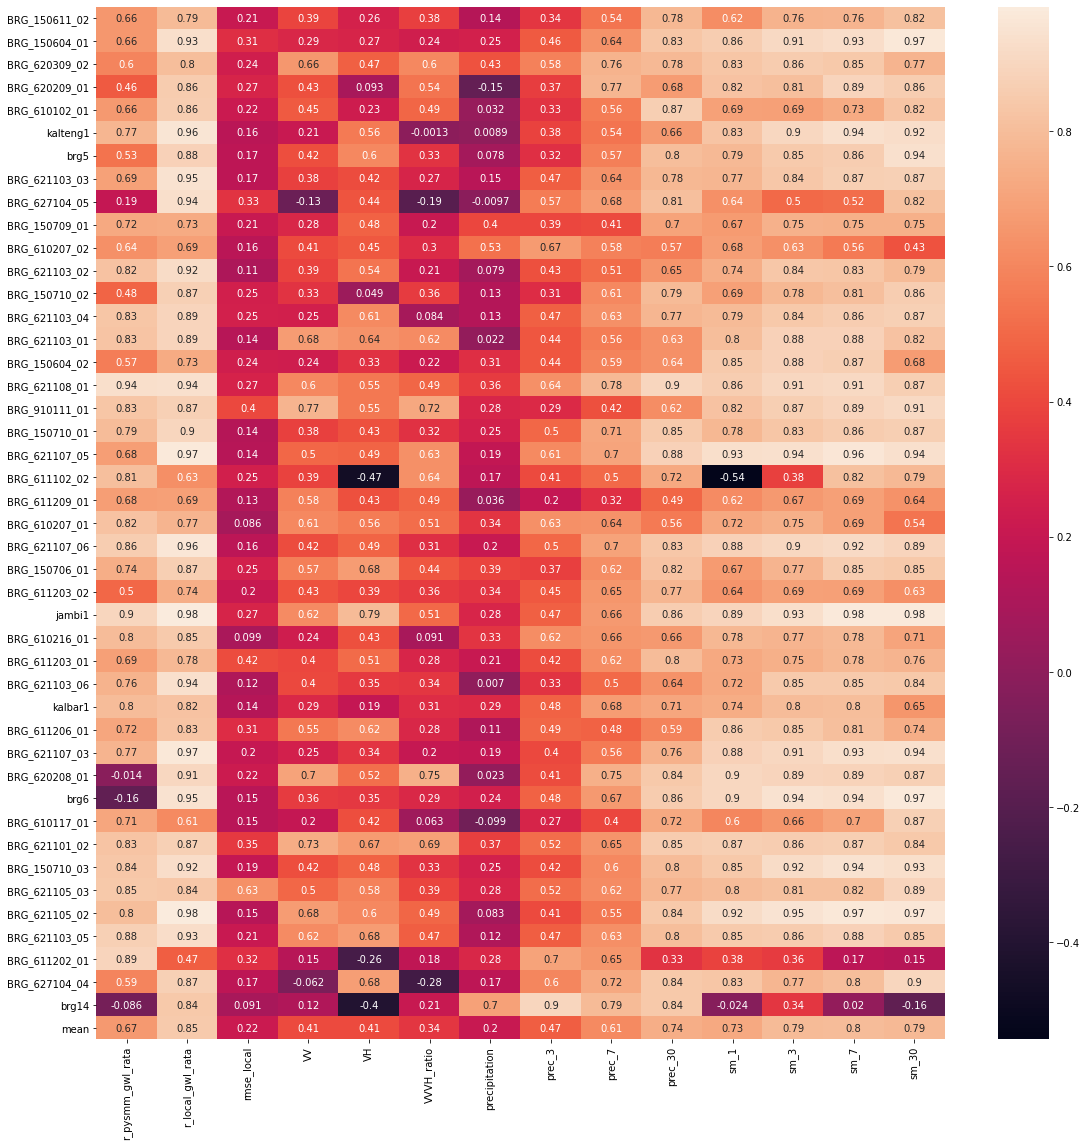

In [29]:
stats_df2.columns = cols
stats_df2.loc['mean'] = stats_df2.mean()
sns.heatmap(stats_df2, annot=True)
#plt.savefig('/home/vollrath/Indonesia_sm/figures/correlations/correlation2_GWL_cleaned_37.png')

In [ ]:
stats_df2.mean()

In [30]:
# split gdf into good statoins for train
gdf_high = clean_df[clean_df.station.isin(final_stations)].copy()
# and bad stations for test
gdf_low = clean_df[~clean_df.station.isin(final_stations)].copy()

variable = 'GWL_rata'

# create and train classifier
regr = RandomForestRegressor(n_estimators=250, min_samples_leaf=1, random_state=42, oob_score=True, criterion='mse', n_jobs=-1)
regr.fit(gdf_high[bandlist], gdf_high[variable])


row = {}
#rmse_list = []
for station in gdf_low.station.unique():
    
    # add first element gwl-smm correlation to station
    explans = [stations['corr_gwl'][stations.stasiun == station].values[0]]
    
    # apply model to specific station
    gdf_test = gdf_low[gdf_low.station == station]
    y_pred_test = regr.predict(gdf_test[bandlist])
    
    # get pearsons r
    r, p = pearsonr(gdf_test[variable].values, y_pred_test)
    explans.append(r)
    
    explans.append(np.sqrt(mean_squared_error(gdf_test[variable].values, y_pred_test)))
    
    # add correlation of explanatories
    for expl in temporal_expl:
        explans.append(gdf_test[variable].corr(gdf_test[expl]))
        
    row[station] = explans
    #print(row)
    
stats_df3 = pd.DataFrame.from_dict(row, orient='index')


<AxesSubplot:>

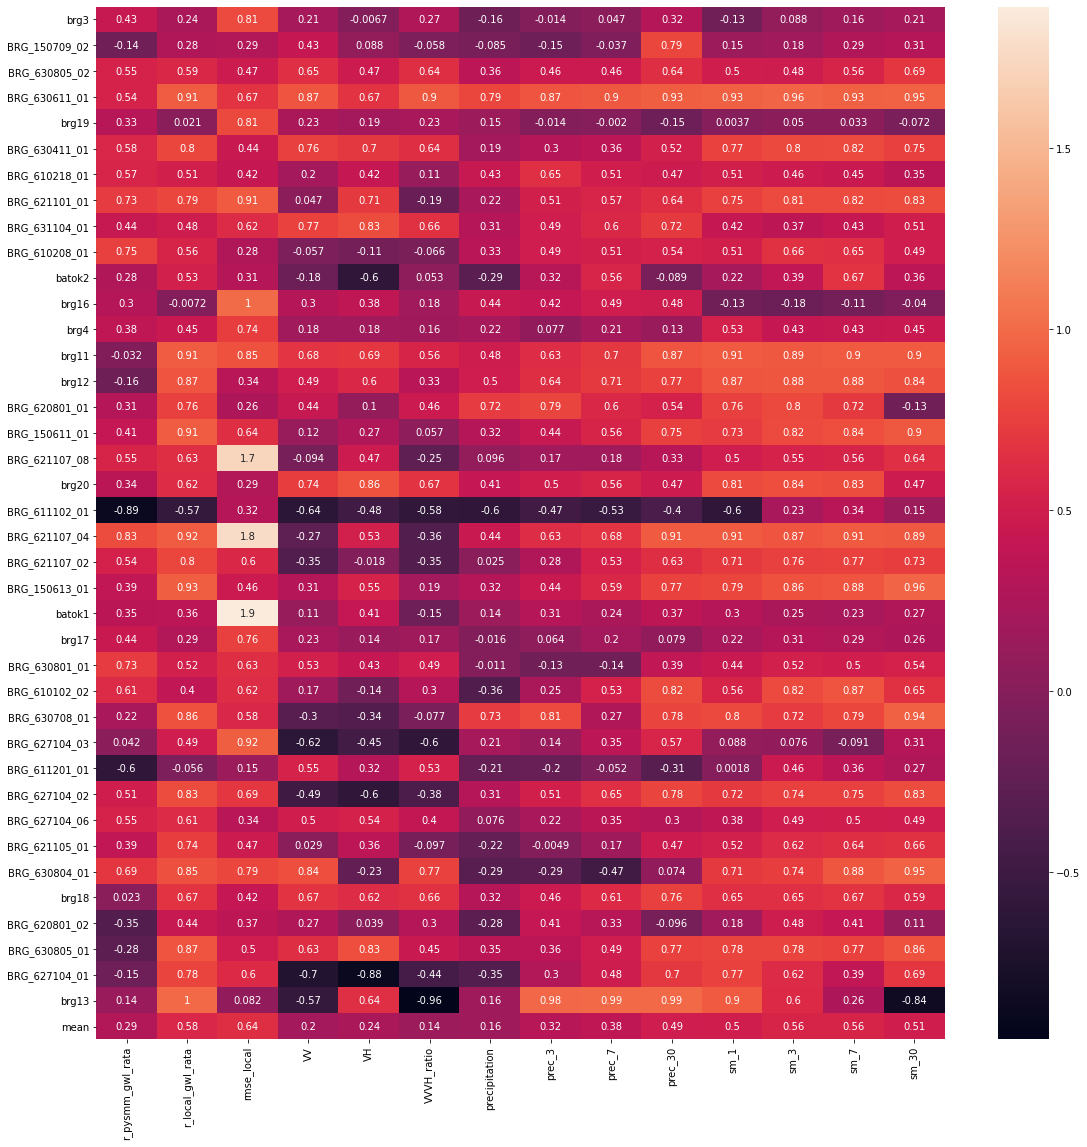

In [32]:
stats_df3.columns = cols
stats_df3.loc['mean'] = stats_df3.mean()
stats_df3
sns.heatmap(stats_df3, annot=True)
#plt.savefig('/home/vollrath/Indonesia_sm/figures/correlations/correlation2_GWL_cleaned_others.png')